In [7]:
# 对网络犯罪数据进行kmeans聚类分析
# 导入犯罪数据
import pandas as pd
# Load the data
df = pd.read_csv("vcdb.csv", low_memory=False)
df.head()

,action.environmental.notes,action.environmental.variety.Deterioration,action.environmental.variety.Earthquake,action.environmental.variety.EMI,action.environmental.variety.ESD,action.environmental.variety.Fire,action.environmental.variety.Flood,action.environmental.variety.Hazmat,action.environmental.variety.Humidity,action.environmental.variety.Hurricane,...,pattern.Basic Web Application Attacks,pattern.System Intrusion,pattern.Social Engineering,pattern.Denial of Service,pattern.Everything Else,actor.Multiple,Actor,victim.industry2.31_33,victim.industry2.44_45,victim.industry2.48_49
0,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,Internal,False,False,False
1,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,Internal,False,False,False
2,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,External,False,False,False
3,NaN,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,Partner,False,False,False
4,NaN,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,External,False,False,False


In [15]:
bool_cols = df.select_dtypes(include='bool').columns.tolist()
country_cols = [col for col in bool_cols if '.country.' in col]  # 筛选国家相关的布尔列
non_country_bool_cols = list(set(bool_cols) - set(country_cols))  # 非国家布尔列

# 提取所有唯一国家代码
countries = list(set([col.split('.')[-1] for col in country_cols]))

# 初始化国家-指标矩阵
country_matrix = pd.DataFrame(0, index=countries, columns=non_country_bool_cols)

# 步骤2：遍历每个国家统计指标
for country in countries:
    # 找到该国家对应的所有列（如victim.country.US, actor.external.country.US等）
    country_mask_cols = [col for col in country_cols if col.endswith(f'.{country}')]

    # 筛选出涉及该国家的所有行（任意国家相关列为True）
    country_rows = df[df[country_mask_cols].any(axis=1)]

    # 统计非国家布尔列的True总数
    country_matrix.loc[country] = country_rows[bool_cols].sum()



In [19]:
import pandas as pd

# ----------------------------------
# 1. 统计国家作为受害者的次数（victim.country.XX）
# ----------------------------------
victim_country_cols = [col for col in df.columns if col.startswith('victim.country.')]
# 提取国家代码（如 'US'）
victim_countries = [col.split('.')[-1] for col in victim_country_cols]
# 按列求和，得到每个国家被攻击的次数
victim_counts = df[victim_country_cols].sum().values
victim_df = pd.DataFrame({'victim_count': victim_counts}, index=victim_countries)

# ----------------------------------
# 2. 统计国家作为外部攻击者的次数（actor.external.country.XX）
# ----------------------------------
external_country_cols = [col for col in df.columns if col.startswith('actor.external.country.')]
# 提取国家代码（如 'CN'）
external_countries = [col.split('.')[-1] for col in external_country_cols]
# 按列求和，得到每个国家作为外部攻击者的次数
external_counts = df[external_country_cols].sum().values
external_df = pd.DataFrame({'external_count': external_counts}, index=external_countries)

# ----------------------------------
# 3. 合并两个统计结果
# ----------------------------------
# 以所有国家代码的并集为索引，缺失值填充0
all_countries = list(set(victim_countries + external_countries))
result = pd.DataFrame(index=all_countries)
result = result.join(victim_df, how='left').join(external_df, how='left').fillna(0)

# 把result输出成csv
result.to_csv("country_attack_counts.csv")
# 输出结果（按受害次数排序）
print(result.sort_values('victim_count', ascending=False))

         victim_count  external_count
US               7493             330
GB                592              49
CA                380              22
Unknown           219            4236
AU                174              13
...               ...             ...
LY                  0               1
TV                  0               0
TK                  0               0
BF                  0               0
IO                  0               0

[252 rows x 2 columns]


In [56]:
import pandas as pd

# 读取两个文件，只保留需要的列并重命名
df_v = pd.read_csv("valid_data_v.csv", usecols=["country_code", "attack_density"]).rename(columns={"attack_density": "vd"})
df_a = pd.read_csv("valid_data_a.csv", usecols=["country_code", "attack_density"]).rename(columns={"attack_density": "ad"})

# 按国家代码合并
merged_df = pd.merge(df_v, df_a, on="country_code", how="outer")

# 设置国家代码为索引
merged_df.set_index("country_code", inplace=True)
# 删除所有vd或ad大于0.5或等于0的行
merged_df = merged_df[(merged_df['vd'] > 0) & (merged_df['vd'] < 23) & (merged_df['ad'] > 0) & (merged_df['ad'] < 23)]


# 查看结果
print(merged_df)

                    vd        ad
country_code                    
AF            0.049729  0.049729
AL            0.704785  0.352393
AM            2.024815  0.674938
AR            0.286490  0.176302
AT            0.784999  0.112143
...                ...       ...
UY            0.287875  0.287875
UZ            0.087637  0.029212
VE            0.211001  0.035167
VN            0.051367  0.041094
YE            0.033528  0.033528

[74 rows x 2 columns]


In [57]:
# 计算受害密度（vd）的最大值
max_vd = merged_df['vd'].max()

# 标准化到0-100范围
merged_df['X'] = (merged_df['vd'] / max_vd) * 100

# 处理可能的除零错误（如果所有vd均为0）
if max_vd == 0:
    merged_df['X'] = 0  # 所有X设为0

# 查看结果
print("\nX坐标计算结果：")
print(merged_df[['vd', 'X']].sort_values('X', ascending=False).head())


X坐标计算结果：
                     vd           X
country_code                       
US            22.741612  100.000000
NZ            20.848494   91.675536
IE            14.215000   62.506562
CA             9.998622   43.966197
GB             8.807519   38.728651


In [59]:
# 计算攻击密度（ad）的降序排名（从1开始）
merged_df['ad_rank'] = merged_df['ad'].rank(ascending=False, method='min')


# 国家总数
N = len(merged_df) - 1

# 计算Y坐标
merged_df['Y'] = 100 * (N - merged_df['ad_rank']) / (N - 1)

# 查看结果
print("\nY坐标计算结果：")
print(merged_df[['ad', 'ad_rank', 'Y']].sort_values('Y', ascending=False).head())

merged_df.Y.mean()


Y坐标计算结果：
                    ad  ad_rank           Y
country_code                               
BZ            7.544873      1.0  100.000000
RU            6.072000      2.0   98.611111
IS            2.729071      3.0   97.222222
SY            2.171347      4.0   95.833333
EE            1.502565      5.0   94.444444


np.float64(49.30555555555556)

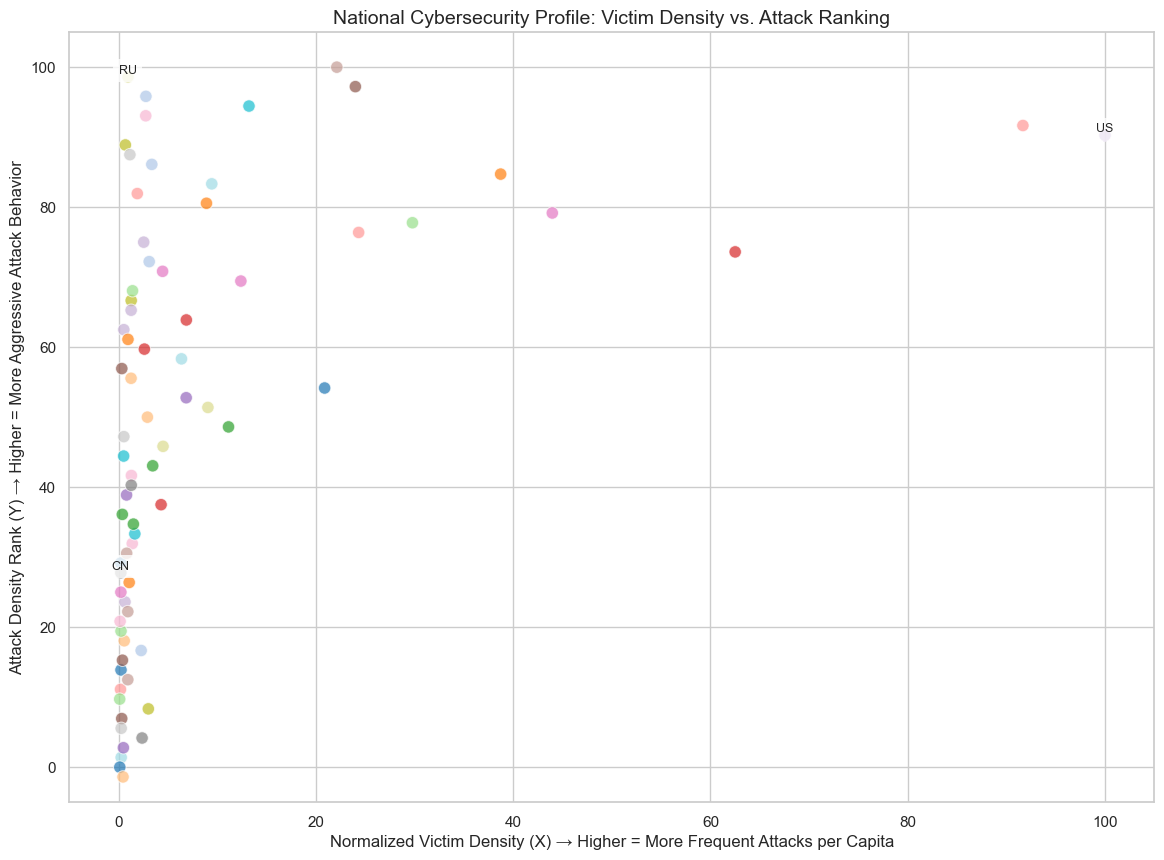

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置图表样式
plt.figure(figsize=(14, 10))
sns.set_theme(style="whitegrid")

# 绘制散点图
scatter = sns.scatterplot(
    x='X',
    y='Y',
    data=merged_df,
    hue=merged_df.index,  # 按国家代码着色（可选）
    palette='tab20',      # 使用多色调色板
    s=80,                 # 点大小
    alpha=0.7,
    legend=False          # 关闭图例（避免过多标签）
)

# 标注关键国家
highlight_countries = ['US', 'RU', 'CN']
for country in highlight_countries:
    if country in merged_df.index:
        x = merged_df.loc[country, 'X']
        y = merged_df.loc[country, 'Y']
        plt.text(x, y, country,
                 fontsize=9,
                 ha='center',
                 va='bottom',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# 设置坐标轴标签和标题
plt.title("National Cybersecurity Profile: Victim Density vs. Attack Ranking", fontsize=14)
plt.xlabel("Normalized Victim Density (X) → Higher = More Frequent Attacks per Capita", fontsize=12)
plt.ylabel("Attack Density Rank (Y) → Higher = More Aggressive Attack Behavior", fontsize=12)

# 调整坐标轴范围（可选）
plt.xlim(-5, 105)
plt.ylim(-5, 105)

# 处理异常值（例如UMI）
if 'UMI' in merged_df.index:
    plt.text(merged_df.loc['UMI', 'X'], merged_df.loc['UMI', 'Y'], 'UMI (Outlier)',
             fontsize=8, color='red', ha='center', va='bottom')

# 显示图表
plt.show()

In [70]:
import pandas as pd

# 1. 读取数据
df = pd.read_csv('vcdb.csv', low_memory=False)

# 2. 筛选出包含国家信息的记录（假设国家字段以'victim.country.'开头）
country_columns = [col for col in df.columns if col.startswith('victim.country.')]
df = df[df[country_columns].any(axis=1)].copy()

# 3. 定义评分函数
def calculate_score(row):
    score = 0

    # 指标1: 攻击被主动检测（Security alarm为True）
    if row.get('discovery_method.internal.variety.Security alarm', False) == True:
        score += 20

    # 指标2: 无数据泄露（data_disclosure.No为True）
    if row.get('attribute.confidentiality.data_disclosure.No', False) == True:
        score += 20

    # 指标3: 恶意软件未部署成功（result.NA为True）
    if row.get('action.malware.result.NA', False) == True:
        score += 20

    # 指标4: 漏洞未被利用（Exploit vuln为False）
    if row.get('action.hacking.variety.Exploit vuln', True) == False:  # 默认True表示漏洞被利用
        score += 20

    # 指标5: 无实质性损失（Insignificant为True）
    if row.get('impact.overall_rating.Insignificant', False) == True:
        score += 20

    return score

# 4. 应用评分函数
df['score'] = df.apply(calculate_score, axis=1)

# 5. 提取国家信息（将one-hot编码转换为国家名称）
def get_country(row):
    for col in country_columns:
        if row[col] == True:
            return col.split('.')[-1]  # 例如 'victim.country.US' -> 'US'
    return None

df['country'] = df.apply(get_country, axis=1)
df = df[df['country'].notna()]

# 6. 按国家聚合计算
result = df.groupby('country').agg(
    total_attacks=('score', 'count'),
    total_score=('score', 'sum')
).reset_index()

result['Z_value'] = (result['total_score'] / result['total_attacks']).round(2)
# df的index设为country
result.set_index('country', inplace=True)

# 7. 输出结果
print(result.sort_values(by='Z_value', ascending=False))

# 可选：保存到文件
result.to_csv('defense_success_rate_by_country.csv', index=False)

         total_attacks  total_score  Z_value
country                                     
AG                   1           40    40.00
GU                   1           40    40.00
HN                   3          120    40.00
UY                   1           40    40.00
RW                   1           40    40.00
...                ...          ...      ...
CH                  19          360    18.95
US                7492       141460    18.88
QA                   3           40    13.33
GT                   2           20    10.00
LK                   2            0     0.00

[141 rows x 3 columns]


In [122]:
# 直接通过索引合并（使用 join）
merged_with_z = merged_df.join(result[['Z_value']], how='left')

# 填充缺失值
merged_with_z['Z_value'] = merged_with_z['Z_value'].fillna(0)


merged_with_z = merged_with_z.rename(columns={'Z_value': 'Z'})

z_min = merged_with_z['Z'].min()
z_max = merged_with_z['Z'].max()

if z_min == z_max:
    merged_with_z['Z_normalized'] = 50.0
else:
    # 線性映射到0-100
    merged_with_z['Z_normalized'] = (merged_with_z['Z'] - z_min) / (z_max - z_min) * 100



# 刪除原始 Z 列（可選）
merged_with_z = merged_with_z.drop(columns=['Z'])

# 重命名新列為 Z
merged_with_z = merged_with_z.rename(columns={'Z_normalized': 'Z'})


merged_with_z[['X', 'Y', 'Z']]


,X,Y,Z
country_code,,,
AF,0.218668,29.166667,5.303030
AL,3.099101,72.222222,52.651515
AM,8.903568,80.555556,36.884470
AR,1.259762,55.555556,56.297348
AT,3.451819,43.055556,32.339015
...,...,...,...
UY,1.265852,65.277778,100.000000
UZ,0.385360,15.277778,5.303030
VE,0.927817,22.222222,100.000000


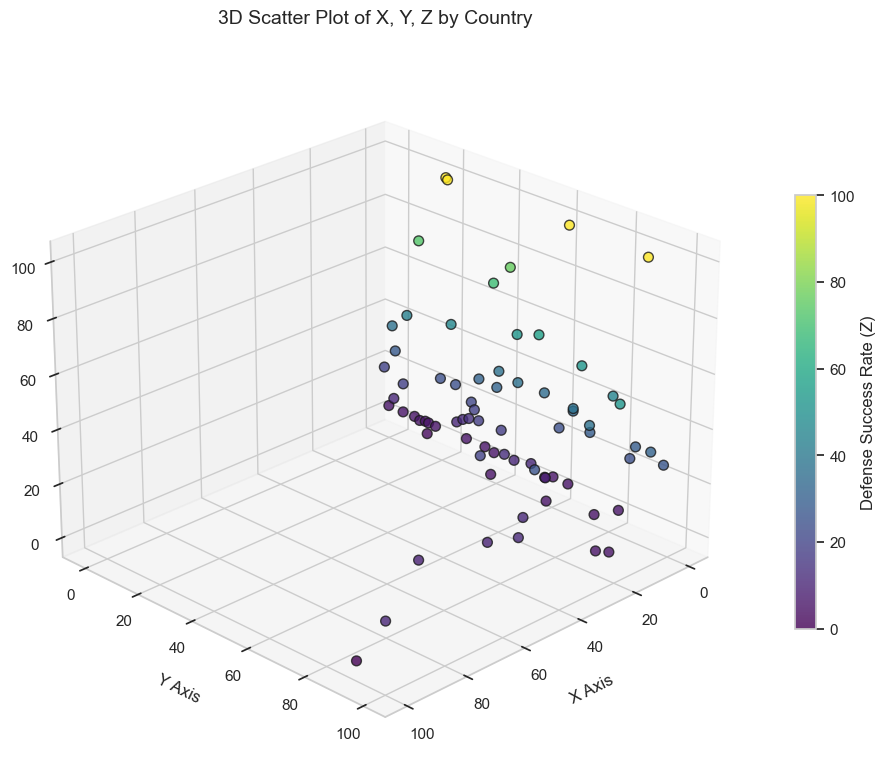

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# 提取数据
x = merged_with_z['X']
y = merged_with_z['Y']
z = merged_with_z['Z']

# 创建三维画布
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 绘制散点图
scatter = ax.scatter(
    x, y, z,
    c=z,  # 颜色映射到 Z 值
    cmap='viridis',  # 颜色方案
    s=50,           # 点大小
    alpha=0.8,      # 透明度
    edgecolor='k'   # 点边框颜色
)

# 添加颜色条
cbar = fig.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label('Defense Success Rate (Z)', fontsize=12)

# 设置坐标轴标签
ax.set_xlabel('X Axis', fontsize=12, labelpad=10)
ax.set_ylabel('Y Axis', fontsize=12, labelpad=10)
ax.set_zlabel('Z Axis (1-100)', fontsize=12, labelpad=10)

# 设置标题和视角
ax.set_title('3D Scatter Plot of X, Y, Z by Country', fontsize=14, pad=20)
ax.view_init(elev=25, azim=45)  # 调整视角

# 优化显示
plt.tight_layout()
plt.show()

In [124]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


df = merged_with_z.drop(columns=['ad', 'vd', 'ad_rank'])
features = df[['X', 'Y', 'Z']]

# 标准化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-means聚类
kmeans = KMeans(n_clusters=4)
df['cluster'] = kmeans.fit_predict(scaled_features)

# 结果分析
print(df.groupby('cluster').mean())

                 X          Y          Z
cluster                                 
0         7.873624  73.009259  21.399937
1         0.929509  44.290123  80.739689
2        67.375389  83.888889   8.172348
3         1.163593  21.342593  17.359533


In [126]:
# US RU CN 的 cluster
print(df.loc['US', 'cluster'])
print(df.loc['RU', 'cluster'])
print(df.loc['CN', 'cluster'])


2
0
3
